<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_4/capstone/4_5b_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Fellow Citizens:
#### Natural Language Processing Model of Inaugural Addresses

### Table of Contents
1. Preprocessing
    - Import Data and Packages
    - EDA
    - Feature Engineering
    - Clean Data
    - Parse Data
2. Feature Extraction
    - Bag of Words
    - Tf-idf
3. Model Selection
    - Split Test/Training Data
    - Clustering
        - K-Means
        - Mean Shift
        - Spectral Clustering
        - Affinity Propagation
    - Supervised Learning
        - L1/l2 Regression
        - Random Forest
        - Support Vector Machine
    - Assessment
4. Model Tuning
    - Dimensionality Reduction
    - Supervised/Unsupervised Model Comparrison
5. Conclusion

### Import data and packages

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score

In [2]:
filename = 'inaugural'
df_prez = pd.read_csv(filename+".csv", index_col=0)
df_prez.head()

,fileid,target,era,year,president,party,recession,wartime,text_raw,length_raw,text_clean,length_clean,text_parsed,length_parsed,text_nostops,length_nostops
0,1789-Washington.txt,NaN,founding,1789,washington,federalist,0,0,Fellow-Citizens of the Senate and of the House...,8619,fellow citizens of the senate and of the house...,8427,"['fellow', 'citizen', 'of', 'the', 'senate', '...",1394,"['fellow', 'citizen', 'senate', 'house', 'repr...",579
1,1793-Washington.txt,NaN,founding,1793,washington,federalist,0,0,"Fellow citizens, I am again called upon by the...",791,fellow citizens am again called upon by the vo...,763,"['fellow', 'citizen', 'be', 'again', 'call', '...",129,"['fellow', 'citizen', 'call', 'voice', 'countr...",56
2,1797-Adams.txt,NaN,founding,1797,adams,federalist,0,0,"When it was first perceived, in early times, t...",13877,when it was first perceived in early times tha...,13473,"['when', '-PRON-', 'be', 'first', 'perceive', ...",2257,"['perceive', 'early', 'time', 'middle', 'cours...",976
3,1801-Jefferson.txt,NaN,founding,1801,jefferson,democratic-republican,0,0,Friends and Fellow Citizens:\n\nCalled upon to...,10137,friends and fellow citizens called upon to und...,9835,"['friend', 'and', 'fellow', 'citizen', 'call',...",1688,"['friend', 'fellow', 'citizen', 'call', 'under...",723
4,1805-Jefferson.txt,NaN,founding,1805,jefferson,democratic-republican,0,0,"Proceeding, fellow citizens, to that qualifica...",12908,proceeding fellow citizens to that qualificati...,12598,"['proceed', 'fellow', 'citizen', 'to', 'that',...",2128,"['proceed', 'fellow', 'citizen', 'qualificatio...",902


In [11]:
filename = 'inaugural_word_counts'
word_counts = pd.read_csv(filename+".csv", index_col=0)
word_counts.head()

,fileid,text_nostops,government,people,nation,state,great,country,world,power,shall,citizen,time,law,right,peace,good,new,man,american,public,america,duty,constitution,war,free,interest,freedom,united,union,life,year,hope,national,principle,know,let,fellow,work,spirit,...,scope,relative,faction,occasionally,widen,dependence,abolish,columbia,fullness,overcome,probably,uniform,betray,monarchy,complain,potent,strange,mischief,minister,corner,absence,clothe,joint,prudent,accession,inform,temple,annual,asia,levy,economical,rightfully,consume,opening,unmindful,active,sorrow,furnace,justification,channel
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",9,4,3,2,4,5,1,2,3,5,1,0,2,0,3,1,1,2,6,0,5,1,0,2,1,0,4,2,1,1,2,1,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",1,1,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",18,20,20,12,5,10,3,6,4,6,3,2,2,5,7,1,4,3,6,5,3,9,1,2,4,0,3,2,2,5,1,4,3,0,0,3,0,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",13,2,4,3,4,4,3,5,6,7,0,4,6,5,8,0,9,0,4,0,2,2,1,3,0,4,0,2,1,0,2,0,9,1,7,7,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",3,0,6,12,1,5,2,4,7,10,6,6,4,4,4,1,3,1,14,0,8,6,4,1,8,2,1,3,2,4,0,0,4,2,2,8,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
filename = 'inaugural_tf_idf'
tf_idf = pd.read_csv(filename+".csv", index_col=0)
tf_idf.head()

,fileid,text_nostops,abandon,abandonment,abide,ability,able,abode,abolish,aboriginal,abound,abraham,abreast,abroad,absence,absent,absolute,absolutely,absorb,abstain,abundance,abundant,abundantly,abuse,accept,acceptance,access,accessible,accession,accident,accommodation,accompany,accomplish,accomplishment,accord,accordance,accordingly,account,accountability,accountable,...,wind,window,winter,wipe,wise,wisely,wish,withdraw,wither,withhold,witness,woman,womanhood,wonder,wonderful,word,worker,workingman,worldly,worldwide,worship,worth,worthily,worthy,wound,wrest,writ,write,writer,wrong,yearn,yes,yesterday,yield,yorktown,young,youth,zeal,zealous,zealously
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033835,0.0,0.000000,0.0,0.06622,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061866,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.163159,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",0.030996,0.0,0.0,0.0,0.000000,0.0,0.0,0.040534,0.0,0.0,0.0,0.026315,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.029231,0.0,0.0,0.0,0.0,0.0,0.049085,0.0,0.0,0.000000,0.0,0.029231,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022929,0.0,0.067335,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035532,0.0,0.0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",0.040103,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.034046,0.0,0.0,0.045972,0.0,0.0,0.0,0.0,0.0,0.0,0.075637,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037819,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029665,0.0,0.029039,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035821,0.0,0.059331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045972,0.0,0.0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",0.000000,0.0,0.0,0.0,0.030152,0.0,0.0,0.041811,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.060303,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.030152,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.023152,0.0,0.0,0.0,0.087991,0.0,0.0,0.0,0.000000,0.023651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028559,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109956,0.0,0.0


## Model Selection

#### Split training/test data

In [0]:
from sklearn.model_selection import train_test_split
# set target variable
target = df_prez['recession']

In [0]:
# define data, target for BoW features
#Data_bow = np.array(Word_Counts.drop(['text_sentence','text_source', 'Target'], 1))
Data_bow = word_counts.drop(['fileid', 'text_nostops'], 1)
# split training and testing data
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    Data_bow, target, test_size=0.25, stratify=target, random_state=42)

In [0]:
# define data, target for tf-idf features
#Data_tfidf = np.array(Tf_idf.drop(['text_sentence','text_source'], 1))
Data_tfidf = tf_idf.drop(['fileid', 'text_nostops'], 1)
# split training and testing data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    Data_tfidf, target, test_size=0.25, stratify=target, random_state=42)

In [0]:
# merge BoW features and tf-idf features
df = pd.concat([word_counts, tf_idf.drop(['fileid', 'text_nostops'], axis=1)], axis=1)
# define data and target
#Data = np.array(df.drop(['text_sentence', 'text_source', 'Target'], axis=1))
Data = df.drop(['fileid', 'text_nostops'], axis=1)
# split training and test data
# reserve 25% of data for testing and straify split along target variable
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target, random_state=42)

### Unsupervised Models: Clustering
#### K-Means

In [0]:
from sklearn.cluster import KMeans

In [15]:
# fit model with 2 clusters using BoW features
kmeans_pred_bow = KMeans(n_clusters=2, random_state=42).fit_predict(X_train_bow)
# fit model with 2 clusters using Tf-Idf features
kmeans_pred_tfidf = KMeans(n_clusters=2, random_state=42).fit_predict(X_train_tfidf)
# fit model with 2 clusters using all features
kmeans_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_train)
#
print('K-Means Clustering and Eras (BoW):')
print(pd.crosstab(y_train_bow, kmeans_pred_bow))
print('\nK-Means Clustering and Eras (Tf-Idft):')
print(pd.crosstab(y_train_tfidf, kmeans_pred_tfidf))
print('\nK-Means Clustering and Eras (all features):')
print(pd.crosstab(y_train, kmeans_pred))

K-Means Clustering and Eras (BoW):
col_0      0   1
recession       
0          3  16
1          8  16

K-Means Clustering and Eras (Tf-Idft):
col_0      0   1
recession       
0          8  11
1          9  15

K-Means Clustering and Eras (all features):
col_0      0   1
recession       
0          3  16
1          8  16


In [0]:
# Test results
km_sil_scores_bow = []
km_sil_scores_tfidf = []
km_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores_bow.append(sil_score)

# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores.append(sil_score)

In [18]:
# view silhouette score and variance
# silhouette score of BoW features
print('K-Means')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    km_sil_scores_bow[0]*100,
    km_sil_scores_bow[1]*100,
    np.var(km_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    km_sil_scores_tfidf[0]*100,
    km_sil_scores_tfidf[1]*100,
    np.var(km_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    km_sil_scores[0]*100,
    km_sil_scores[1]*100,
    np.var(km_sil_scores)*100))

K-Means
Silhouette score of BoW features:
Training: 20.767487551145354, Test: 11.619788344110207 +/- 0.20920100195597857 %

Silhouette score of Tf-Idf features:
Training: 2.9067297967773507, Test: 3.3037504544678233 +/- 0.00039406350658243924 %

Silhouette score of all features:
Training: 20.758908426745496, Test: 11.612529437979086 +/- 0.20914062151536914 %


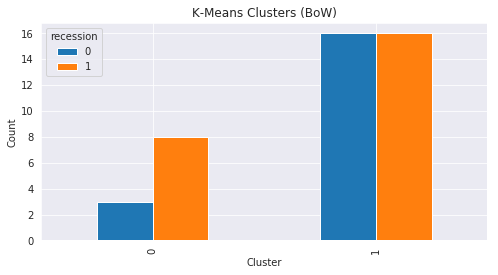

In [19]:
# K Means Clusters of BoW features
prediction = pd.crosstab(kmeans_pred_bow, y_train_bow)
prediction.plot(kind='bar', stacked=False, figsize=[8,4])
plt.title('K-Means Clusters (BoW)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Mean Shift

In [0]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [21]:
# fit model using BoW features
bandwidth_bow = estimate_bandwidth(X_train_bow, quantile=0.3)
ms_pred_bow = MeanShift(bandwidth=bandwidth_bow, bin_seeding=True).fit_predict(X_train_bow)
# fit model using Tf-Idf features
bandwidth_tfidf = estimate_bandwidth(X_train_tfidf, quantile=0.3)
ms_pred_tfidf = MeanShift(bandwidth=bandwidth_tfidf, bin_seeding=True).fit_predict(X_train_tfidf)
# fit model using all features
bandwidth = estimate_bandwidth(X_train, quantile=0.3)
ms_pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_train)
#
print('Mean Shift and Eras (BoW):')
print(pd.crosstab(y_train_bow, ms_pred_bow))
print('\nMean Shift and Eras (Tf-Idft):')
print(pd.crosstab(y_train_tfidf, ms_pred_tfidf))
print('\nMean Shift and Eras (all features):')
print(pd.crosstab(y_train, ms_pred))

Mean Shift and Eras (BoW):
col_0       0
recession    
0          19
1          24

Mean Shift and Eras (Tf-Idft):
col_0       0
recession    
0          19
1          24

Mean Shift and Eras (all features):
col_0       0
recession    
0          19
1          24


In [27]:
# Test results
ms_sil_scores_bow = []
ms_sil_scores_tfidf = []
ms_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
    # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores_bow.append(sil_score)

# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
  # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
    # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores.append(sil_score)

ValueError: ignored

In [28]:
# view silhouette score and variance
# silhouette score of BoW features
print('Mean Shift\n')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    ms_sil_scores_bow[0],
    ms_sil_scores_bow[1],
    np.var(ms_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    ms_sil_scores_tfidf[0],
    ms_sil_scores_tfidf[1],
    np.var(ms_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    ms_sil_scores[0],
    ms_sil_scores[1],
    np.var(ms_sil_scores)*100))

Mean Shift

Silhouette score of BoW features:
Training: 0.16167772685718232, Test: 0.14342629167393287 +/- 0.0083278721562089 %

Silhouette score of Tf-Idf features:


IndexError: ignored

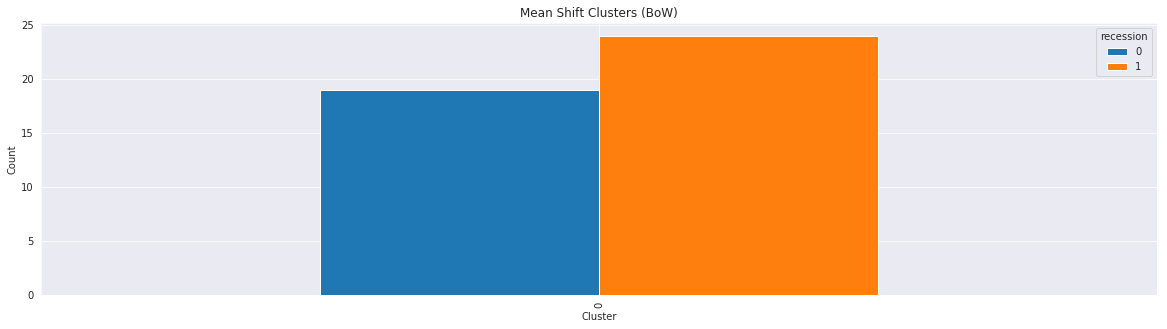

In [29]:
# Mean Shift Clusters of BoW features
prediction = pd.crosstab(ms_pred_bow, y_train_bow)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Mean Shift Clusters (BoW)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Spectral Clustering

In [0]:
from sklearn.cluster import SpectralClustering

In [31]:
# fit model using BoW features
sc_pred_bow = SpectralClustering(n_clusters=2).fit_predict(X_train_bow)
# fit model using Tf-Idf features
sc_pred_tfidf = SpectralClustering(n_clusters=2).fit_predict(X_train_tfidf)
# fit model using all features
sc_pred = SpectralClustering(n_clusters=2).fit_predict(X_train)
#
print('Spectral Clusters and Eras (BoW):')
#print(pd.crosstab(y_train_bow, sc_pred_bow))
print('\nSpectral Clusters and Eras (Tf-Idft):')
#print(pd.crosstab(y_train_tfidf, sc_pred_tfidf))
print('\nSpectral Clusters and Eras (all features):')
#print(pd.crosstab(y_train, sc_pred))

Spectral Clusters and Eras (BoW):

Spectral Clusters and Eras (Tf-Idft):

Spectral Clusters and Eras (all features):


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

In [32]:
# Test results
sc_sil_scores_bow = []
sc_sil_scores_tfidf = []
sc_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  model = SpectralClustering(n_clusters=15, random_state=42)
#  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores_bow.append(sil_score)
# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  model = SpectralClustering(n_clusters=4, random_state=42)
#  model = KMeans(n_clusters=4, random_state=42)
  model.fit_predict(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  model = SpectralClustering(n_clusters=4, random_state=42)
#  model = KMeans(n_clusters=4, random_state=42)
  model.fit_predict(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores.append(sil_score)

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pai

ValueError: ignored

In [33]:
# view silhouette score and variance
# silhouette score of BoW features
print('Spectral Clustering')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    sc_sil_scores_bow[0],
    sc_sil_scores_bow[1],
    np.var(sc_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    sc_sil_scores_tfidf[0],
    sc_sil_scores_tfidf[1],
    np.var(sc_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    sc_sil_scores[0],
    sc_sil_scores[1],
    np.var(sc_sil_scores)*100))

Spectral Clustering
Silhouette score of BoW features:


IndexError: ignored

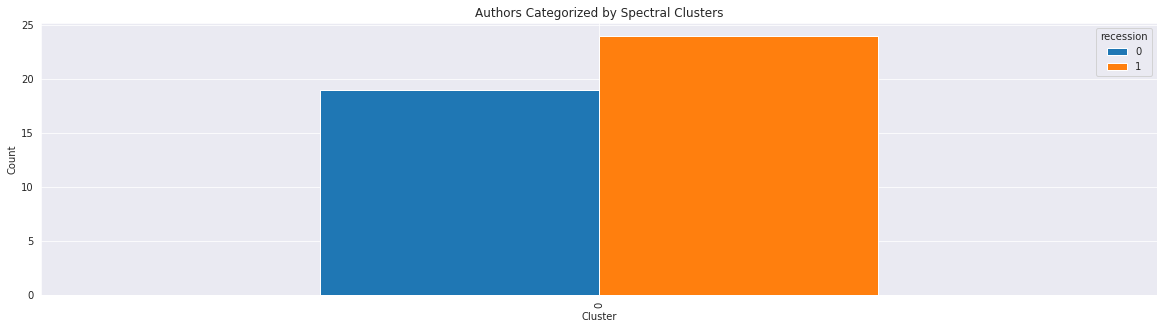

In [34]:
#Show authors categorized by cluster
prediction = pd.crosstab(sc_pred_bow, y_train)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by Spectral Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Affinity Propagation

In [0]:
from sklearn.cluster import AffinityPropagation

In [36]:
# fit model using BoW features
af_pred_bow = AffinityPropagation().fit_predict(X_train_bow)
# fit model using Tf-Idf features
af_pred_tfidf = AffinityPropagation().fit_predict(X_train_tfidf)
# fit model using all features
af_pred = AffinityPropagation().fit_predict(X_train)
#
print('Spectral Clusters and Eras (BoW):')
print(pd.crosstab(y_train_bow, af_pred_bow))
print('\nSpectral Clusters and Eras (Tf-Idft):')
print(pd.crosstab(y_train_tfidf, af_pred_tfidf))
print('\nSpectral Clusters and Eras (all features):')
print(pd.crosstab(y_train, af_pred))

Spectral Clusters and Eras (BoW):
col_0      0  1  2  3  4  5   6  7  8  9
recession                               
0          0  0  0  1  0  0   8  0  9  1
1          1  1  2  0  1  1  10  1  7  0

Spectral Clusters and Eras (Tf-Idft):
col_0      0  1  2  3  4  5  6
recession                     
0          1  1  1  3  6  6  1
1          3  4  4  3  2  8  0

Spectral Clusters and Eras (all features):
col_0      0  1  2  3  4  5   6  7  8  9
recession                               
0          0  0  0  1  0  0   8  0  9  1
1          1  1  2  0  1  1  10  1  7  0


In [0]:
# Test results
af_sil_scores_bow = []
af_sil_scores_tfidf = []
af_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  model = AffinityPropagation().fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  af_sil_scores_bow.append(sil_score)

# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  model = AffinityPropagation().fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  af_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  model = AffinityPropagation().fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  af_sil_scores.append(sil_score)

In [38]:
# view silhouette score and variance
# silhouette score of BoW features
print('Affinity Propagation')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    af_sil_scores_bow[0],
    af_sil_scores_bow[1],
    np.var(af_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    af_sil_scores_tfidf[0],
    af_sil_scores_tfidf[1],
    np.var(af_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    af_sil_scores[0],
    af_sil_scores[1],
    np.var(af_sil_scores)*100))

Affinity Propagation
Silhouette score of BoW features:
Training: 0.08196864447976479, Test: 0.18778667677813823 +/- 0.2799363989874901 %

Silhouette score of Tf-Idf features:
Training: 0.010036582700326584, Test: 0.028926467770034544 +/- 0.008920693948669393 %

Silhouette score of all features:
Training: 0.08193588516246396, Test: 0.18769469725397572 +/- 0.27962315837519236 %


Of our four unsupervised models (K-Means, Mean Shift, Spectral Clustering, and Affinity propagation), the best model was K-Means with the Bag of Words features

### Supervised Models
#### L1 Regularization

In [0]:
from sklearn.linear_model import LogisticRegression

# set penalty to 'l1'
# set penalty to 'saga'
lasso = LogisticRegression(penalty='l1',
                           solver='saga',
                           multi_class='auto',
                           random_state=42,
                           #max_iter=1500
                          )
# fit BoW features
lasso_bow = lasso.fit(X_train_bow, y_train_bow)
print('Lasso Regression (all features)')
print('\nTraining set score:', lasso_bow.score(X_train_bow, y_train_bow))
print('\nTest set score:', lasso_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(lasso_bow, Data_bow, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Lasso Regression (all features)

Training set score: 0.9767441860465116

Test set score: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 51.8182 +/- 0.6579%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
# fit all features
lasso_tfidf = lasso.fit(X_train_tfidf, y_train_tfidf)
print('Lasso Regression (Tf-Idf)')
print('\nTf-Idf Training set score:', lasso_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', lasso_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(lasso_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Lasso Regression (Tf-Idf)

Tf-Idf Training set score: 0.5581395348837209

Tf-Idf Test set score: 0.6

Cross validation (Tf-Idf): 56.8182 +/- 0.0344%


In [0]:
# fit all features
lasso = lasso.fit(X_train, y_train)
print('Lasso Regression (all features)')
print('\nTraining set score:', lasso.score(X_train, y_train))
print('\nTest set score:', lasso.score(X_test, y_test))
cv_scores = cross_val_score(lasso, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Lasso Regression (all features)

Training set score: 0.9767441860465116

Test set score: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 51.8182 +/- 0.6579%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### L2 Regularization

In [0]:
from sklearn.linear_model import LogisticRegression
# set penalty to 'l2'
# set solver to 'lbfgs'
ridge = LogisticRegression(penalty='l2',
                           solver='lbfgs',
                           multi_class='multinomial',
                           random_state=42)
# fit BoW features
ridge_bow = ridge.fit(X_train_bow, y_train_bow)
print('Ridge Regression (BoW)')
print('\nBoW Training set score:', ridge_bow.score(X_train_bow, y_train_bow))
print('\nBoW Test set score:', ridge_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(ridge_bow, Data_bow, target, cv=5)
print('\nCross validation (BoW): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Ridge Regression (BoW)

BoW Training set score: 1.0

BoW Test set score: 0.7333333333333333

Cross validation (BoW): 55.0 +/- 0.25%


In [0]:
# fit Tf-Idf features
ridge_tfidf = ridge.fit(X_train_tfidf, y_train_tfidf)
print('Ridge Regression (Tf-Idf)')
print('\nTf-Idf Training set score:', ridge_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', ridge_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(ridge_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Ridge Regression (Tf-Idf)

Tf-Idf Training set score: 1.0

Tf-Idf Test set score: 0.5333333333333333

Cross validation (Tf-Idf): 55.0 +/- 0.25%


In [0]:
# fit all features
ridge = ridge.fit(X_train, y_train)
print('Ridge Regression (all features)')
print('\nTraining set score:', ridge.score(X_train, y_train))
print('\nTest set score:', ridge.score(X_test, y_test))
cv_scores = cross_val_score(ridge, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Ridge Regression (all features)

Training set score: 1.0

Test set score: 0.7333333333333333

Cross validation: 55.0 +/- 0.25%


#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# set n_estimators = 100
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# fit BoW features
rfc_bow = rfc.fit(X_train_bow, y_train_bow)
print('Random Forest (BoW)')
print('\nBoW Training set score:', rfc_bow.score(X_train_bow, y_train_bow))
print('\nBoW Test set score:', rfc_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(rfc_bow, Data_bow, target, cv=5)
print('\nCross validation (BoW): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Random Forest (BoW)

BoW Training set score: 1.0

BoW Test set score: 0.6666666666666666

Cross validation (BoW): 56.8182 +/- 0.3122%


In [0]:
# fit Tf-Idf features
rfc_tfidf = rfc.fit(X_train_tfidf, y_train_tfidf)
print('Random Forest (Tf-Idf)')
print('\nTf-Idf Training set score:', rfc_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', rfc_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(rfc_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Random Forest (Tf-Idf)

Tf-Idf Training set score: 1.0

Tf-Idf Test set score: 0.6

Cross validation (Tf-Idf): 53.4848 +/- 0.7084%


In [0]:
# fit all features
rfc = rfc.fit(X_train, y_train)
print('Random Forest (all features)')
print('\nTraining set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
cv_scores = cross_val_score(rfc, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Random Forest (all features)

Training set score: 1.0

Test set score: 0.7333333333333333

Cross validation: 56.9697 +/- 1.4219%


#### Support Vector Machines

In [0]:
from sklearn.svm import SVC

In [0]:
# set gamma to 'scale'
svc = SVC(gamma='scale', random_state=42)
# fit BoW features
svc_bow = svc.fit(X_train_bow, y_train_bow)
print('Support Vector Machine (BoW)')
print('\nBoW Training set score:', svc_bow.score(X_train_bow, y_train_bow))
print('\nBoW Test set score:', svc_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(svc_bow, Data_bow, target, cv=5)
print('\nCross validation (BoW): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Support Vector Machine (BoW)

BoW Training set score: 0.8604651162790697

BoW Test set score: 0.6

Cross validation (BoW): 58.6364 +/- 1.023%


In [0]:
# fit Tf-Idf features
svc_tfidf = svc.fit(X_train_tfidf, y_train_tfidf)
print('Support Vector Machine (Tf-Idf)')
print('\nTf-Idf Training set score:', svc_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', svc_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(svc_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Support Vector Machine (Tf-Idf)

Tf-Idf Training set score: 1.0

Tf-Idf Test set score: 0.6

Cross validation (Tf-Idf): 56.8182 +/- 0.0344%


In [0]:
# fit all features
svc = svc.fit(X_train, y_train)
print('Support Vector Machine (all features)')
print('\nTraining set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))
cv_scores = cross_val_score(svc, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Support Vector Machine (all features)

Training set score: 0.8604651162790697

Test set score: 0.6

Cross validation: 56.8182 +/- 0.6428%


Of our four supervised models (L1/L2 regularization, Random Forest, and Support Vector Machines), the best model was Ridge Regression with the Tf-Idf features

## Model Selection

#### Split training/test data

In [0]:
from sklearn.model_selection import train_test_split
# set target value
target = df_prez['wartime']

In [0]:
# define data, target for BoW features
#Data_bow = np.array(Word_Counts.drop(['text_sentence','text_source', 'Target'], 1))
Data_bow = word_counts.drop(['fileid', 'text_nostops'], 1)
# split training and testing data
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    Data_bow, target, test_size=0.25, stratify=target, random_state=42)

In [0]:
# define data, target for tf-idf features
#Data_tfidf = np.array(Tf_idf.drop(['text_sentence','text_source'], 1))
Data_tfidf = tf_idf.drop(['fileid', 'text_nostops'], 1)
# split training and testing data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    Data_tfidf, target, test_size=0.25, stratify=target, random_state=42)

In [0]:
# merge BoW features and tf-idf features
df = pd.concat([word_counts, tf_idf.drop(['fileid', 'text_nostops'], axis=1)], axis=1)
# define data and target
#Data = np.array(df.drop(['text_sentence', 'text_source', 'Target'], axis=1))
Data = df.drop(['fileid', 'text_nostops'], axis=1)
# split training and test data
# reserve 25% of data for testing and straify split along target variable
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target, random_state=42)

### Unsupervised Models: Clustering
#### K-Means

In [0]:
from sklearn.cluster import KMeans

In [44]:
# fit model with 2 clusters using BoW features
kmeans_pred_bow = KMeans(n_clusters=2, random_state=42).fit_predict(X_train_bow)
# fit model with 2 clusters using Tf-Idf features
kmeans_pred_tfidf = KMeans(n_clusters=2, random_state=42).fit_predict(X_train_tfidf)
# fit model with 2 clusters using all features
kmeans_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_train)
#
print('K-Means Clustering and Eras (BoW):')
print(pd.crosstab(y_train_bow, kmeans_pred_bow))
print('\nK-Means Clustering and Eras (Tf-Idft):')
print(pd.crosstab(y_train_tfidf, kmeans_pred_tfidf))
print('\nK-Means Clustering and Eras (all features):')
print(pd.crosstab(y_train, kmeans_pred))

K-Means Clustering and Eras (BoW):
col_0     0  1
wartime       
0        31  1
1        11  0

K-Means Clustering and Eras (Tf-Idft):
col_0     0  1
wartime       
0        24  8
1         2  9

K-Means Clustering and Eras (all features):
col_0     0  1
wartime       
0        31  1
1        11  0


In [0]:
# Test results
km_sil_scores_bow = []
km_sil_scores_tfidf = []
km_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores_bow.append(sil_score)

# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  labels = model.labels_
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  km_sil_scores.append(sil_score)

In [47]:
# view silhouette score and variance
# silhouette score of BoW features
print('K-Means')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    km_sil_scores_bow[0]*100,
    km_sil_scores_bow[1]*100,
    np.var(km_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    km_sil_scores_tfidf[0]*100,
    km_sil_scores_tfidf[1]*100,
    np.var(km_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    km_sil_scores[0]*100,
    km_sil_scores[1]*100,
    np.var(km_sil_scores)*100))

K-Means
Silhouette score of BoW features:
Training: 9.831043478232072, Test: 19.454911317901562 +/- 0.23154708048856165 %

Silhouette score of Tf-Idf features:
Training: 1.8416939881467536, Test: 3.9086910164117667 +/- 0.01068119178714099 %

Silhouette score of all features:
Training: 9.825002982470153, Test: 19.446512309972128 +/- 0.23143360434801874 %


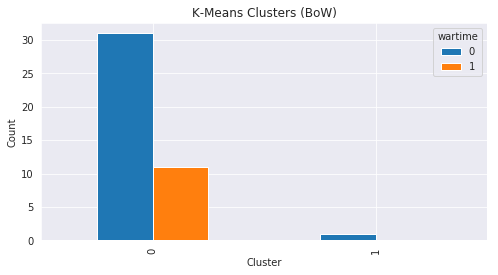

In [48]:
# K Means Clusters of BoW features
prediction = pd.crosstab(kmeans_pred_bow, y_train_bow)
prediction.plot(kind='bar', stacked=False, figsize=[8,4])
plt.title('K-Means Clusters (BoW)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Mean Shift

In [0]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [50]:
# fit model using BoW features
bandwidth_bow = estimate_bandwidth(X_train_bow, quantile=0.3)
ms_pred_bow = MeanShift(bandwidth=bandwidth_bow, bin_seeding=True).fit_predict(X_train_bow)
# fit model using Tf-Idf features
bandwidth_tfidf = estimate_bandwidth(X_train_tfidf, quantile=0.3)
ms_pred_tfidf = MeanShift(bandwidth=bandwidth_tfidf, bin_seeding=True).fit_predict(X_train_tfidf)
# fit model using all features
bandwidth = estimate_bandwidth(X_train, quantile=0.3)
ms_pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_train)
#
print('Mean Shift and Eras (BoW):')
print(pd.crosstab(y_train_bow, ms_pred_bow))
print('\nMean Shift and Eras (Tf-Idft):')
print(pd.crosstab(y_train_tfidf, ms_pred_tfidf))
print('\nMean Shift and Eras (all features):')
print(pd.crosstab(y_train, ms_pred))

Mean Shift and Eras (BoW):
col_0     0
wartime    
0        32
1        11

Mean Shift and Eras (Tf-Idft):
col_0     0
wartime    
0        32
1        11

Mean Shift and Eras (all features):
col_0     0
wartime    
0        32
1        11


In [51]:
# Test results
ms_sil_scores_bow = []
ms_sil_scores_tfidf = []
ms_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
    # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores_bow.append(sil_score)

# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
  # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  bandwidth = estimate_bandwidth(sample, quantile=0.3)
  model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
  # Coordinates of cluster centers
  cluster_centers = model.cluster_centers_
    # Extract clusters for each data point
  labels = model.labels_
  # Count clusters
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  ms_sil_scores.append(sil_score)

ValueError: ignored

In [52]:
# view silhouette score and variance
# silhouette score of BoW features
print('Mean Shift\n')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    ms_sil_scores_bow[0],
    ms_sil_scores_bow[1],
    np.var(ms_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    ms_sil_scores_tfidf[0],
    ms_sil_scores_tfidf[1],
    np.var(ms_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    ms_sil_scores[0],
    ms_sil_scores[1],
    np.var(ms_sil_scores)*100))

Mean Shift

Silhouette score of BoW features:


IndexError: ignored

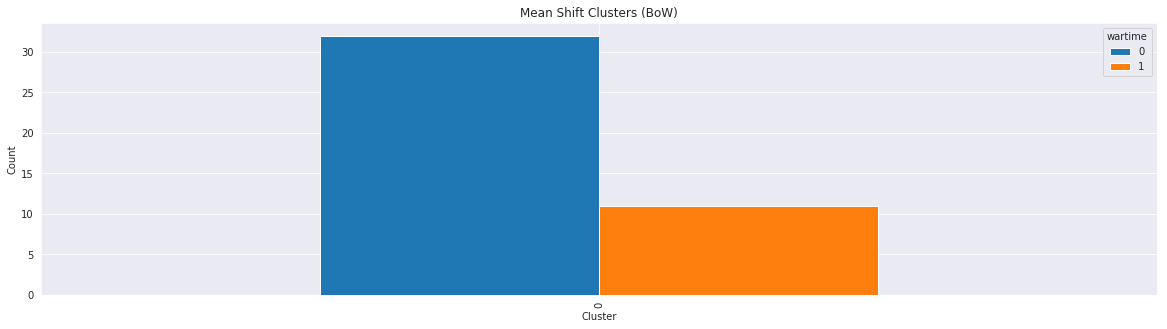

In [53]:
# Mean Shift Clusters of BoW features
prediction = pd.crosstab(ms_pred_bow, y_train_bow)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Mean Shift Clusters (BoW)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Spectral Clustering

In [0]:
from sklearn.cluster import SpectralClustering

In [55]:
# fit model using BoW features
sc_pred_bow = SpectralClustering(n_clusters=2).fit_predict(X_train_bow)
# fit model using Tf-Idf features
sc_pred_tfidf = SpectralClustering(n_clusters=2).fit_predict(X_train_tfidf)
# fit model using all features
sc_pred = SpectralClustering(n_clusters=2).fit_predict(X_train)
#
print('Spectral Clusters and Eras (BoW):')
#print(pd.crosstab(y_train_bow, sc_pred_bow))
print('\nSpectral Clusters and Eras (Tf-Idft):')
#print(pd.crosstab(y_train_tfidf, sc_pred_tfidf))
print('\nSpectral Clusters and Eras (all features):')
#print(pd.crosstab(y_train, sc_pred))

Spectral Clusters and Eras (BoW):

Spectral Clusters and Eras (Tf-Idft):

Spectral Clusters and Eras (all features):


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

In [56]:
# Test results
sc_sil_scores_bow = []
sc_sil_scores_tfidf = []
sc_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  model = SpectralClustering(n_clusters=15, random_state=42)
#  model = KMeans(n_clusters=4, random_state=42)
  model.fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores_bow.append(sil_score)
# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  model = SpectralClustering(n_clusters=4, random_state=42)
#  model = KMeans(n_clusters=4, random_state=42)
  model.fit_predict(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  model = SpectralClustering(n_clusters=4, random_state=42)
#  model = KMeans(n_clusters=4, random_state=42)
  model.fit_predict(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  sc_sil_scores.append(sil_score)

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pai

ValueError: ignored

In [57]:
# view silhouette score and variance
# silhouette score of BoW features
print('Spectral Clustering')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    sc_sil_scores_bow[0],
    sc_sil_scores_bow[1],
    np.var(sc_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    sc_sil_scores_tfidf[0],
    sc_sil_scores_tfidf[1],
    np.var(sc_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    sc_sil_scores[0],
    sc_sil_scores[1],
    np.var(sc_sil_scores)*100))

Spectral Clustering
Silhouette score of BoW features:


IndexError: ignored

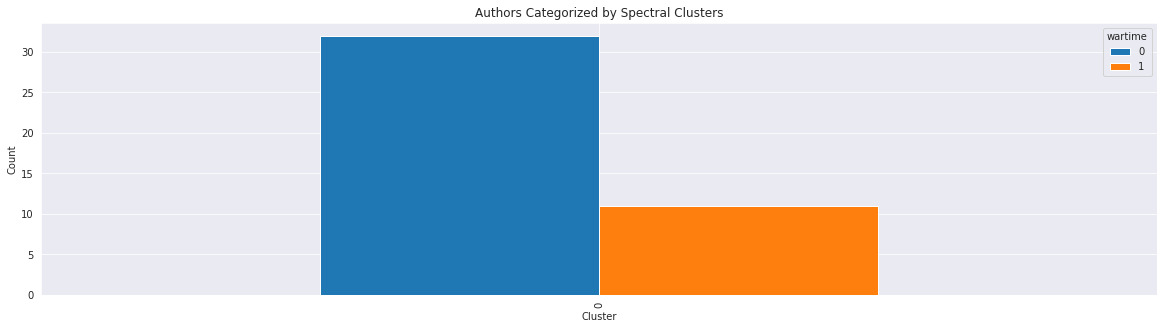

In [58]:
#Show authors categorized by cluster
prediction = pd.crosstab(sc_pred_bow, y_train)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by Spectral Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Affinity Propagation

In [0]:
from sklearn.cluster import AffinityPropagation

In [60]:
# fit model using BoW features
af_pred_bow = AffinityPropagation().fit_predict(X_train_bow)
# fit model using Tf-Idf features
af_pred_tfidf = AffinityPropagation().fit_predict(X_train_tfidf)
# fit model using all features
af_pred = AffinityPropagation().fit_predict(X_train)
#
print('Spectral Clusters and Eras (BoW):')
print(pd.crosstab(y_train_bow, af_pred_bow))
print('\nSpectral Clusters and Eras (Tf-Idft):')
print(pd.crosstab(y_train_tfidf, af_pred_tfidf))
print('\nSpectral Clusters and Eras (all features):')
print(pd.crosstab(y_train, af_pred))

Spectral Clusters and Eras (BoW):
col_0    0   1   2   3   4   5   6   7   8   9   10
wartime                                            
0         1   1   1  11   1   1   1   1   5   9   0
1         0   0   0   0   0   0   0   0   6   4   1

Spectral Clusters and Eras (Tf-Idft):
col_0    0   1  2  3  4
wartime                
0        6  19  1  1  5
1        1   1  7  0  2

Spectral Clusters and Eras (all features):
col_0    0   1   2   3   4   5   6   7   8   9   10
wartime                                            
0         1   1   1  11   1   1   1   1   5   9   0
1         0   0   0   0   0   0   0   0   6   4   1


In [0]:
# Test results
af_sil_scores_bow = []
af_sil_scores_tfidf = []
af_sil_scores = []

# silhouette score of BoW features
for sample in [X_train_bow, X_test_bow]:
  model = AffinityPropagation().fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  af_sil_scores_bow.append(sil_score)

# silhouette score of Tf-Idf features
for sample in [X_train_tfidf, X_test_tfidf]:
  model = AffinityPropagation().fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  af_sil_scores_tfidf.append(sil_score)

# silhouette score of all features
for sample in [X_train, X_test]:
  model = AffinityPropagation().fit(sample)
  # Coordinates of cluster centers
  labels = model.labels_
  n_clusters_ = len(np.unique(labels))
  sil_score = silhouette_score(sample, labels, metric='euclidean')
  af_sil_scores.append(sil_score)

In [62]:
# view silhouette score and variance
# silhouette score of BoW features
print('Affinity Propagation')
print('Silhouette score of BoW features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    af_sil_scores_bow[0],
    af_sil_scores_bow[1],
    np.var(af_sil_scores_bow)*100))
# silhouette score of Tf-Idf features
print('Silhouette score of Tf-Idf features:')
print('Training: {}, Test: {} +/- {} %\n'.format(
    af_sil_scores_tfidf[0],
    af_sil_scores_tfidf[1],
    np.var(af_sil_scores_tfidf)*100))
# silhouette score of all features
print('Silhouette score of all features:')
print('Training: {}, Test: {} +/- {} %'.format(
    af_sil_scores[0],
    af_sil_scores[1],
    np.var(af_sil_scores)*100))

Affinity Propagation
Silhouette score of BoW features:
Training: 0.05602665410013812, Test: 0.1909417968723742 +/- 0.4550523937313211 %

Silhouette score of Tf-Idf features:
Training: 0.023071539046094436, Test: 0.04443847350022089 +/- 0.011413647199173406 %

Silhouette score of all features:
Training: 0.05598648125697213, Test: 0.1908549876897225 +/- 0.4547378506850207 %


Of our four unsupervised models (K-Means, Mean Shift, Spectral Clustering, and Affinity propagation), the best model was K-Means with the Bag of Words features

### Supervised Models
#### L1 Regularization

In [63]:
from sklearn.linear_model import LogisticRegression

# set penalty to 'l1'
# set penalty to 'saga'
lasso = LogisticRegression(penalty='l1',
                           solver='saga',
                           multi_class='auto',
                           random_state=42,
                           #max_iter=1500
                          )
# fit BoW features
lasso_bow = lasso.fit(X_train_bow, y_train_bow)
print('Lasso Regression (all features)')
print('\nTraining set score:', lasso_bow.score(X_train_bow, y_train_bow))
print('\nTest set score:', lasso_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(lasso_bow, Data_bow, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Lasso Regression (all features)

Training set score: 1.0

Test set score: 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 75.303 +/- 3.9109%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [64]:
# fit all features
lasso_tfidf = lasso.fit(X_train_tfidf, y_train_tfidf)
print('Lasso Regression (Tf-Idf)')
print('\nTf-Idf Training set score:', lasso_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', lasso_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(lasso_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Lasso Regression (Tf-Idf)

Tf-Idf Training set score: 0.7441860465116279

Tf-Idf Test set score: 0.7333333333333333

Cross validation (Tf-Idf): 74.0909 +/- 0.0124%


In [65]:
# fit all features
lasso = lasso.fit(X_train, y_train)
print('Lasso Regression (all features)')
print('\nTraining set score:', lasso.score(X_train, y_train))
print('\nTest set score:', lasso.score(X_test, y_test))
cv_scores = cross_val_score(lasso, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Lasso Regression (all features)

Training set score: 1.0

Test set score: 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 75.303 +/- 3.9109%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### L2 Regularization

In [66]:
from sklearn.linear_model import LogisticRegression
# set penalty to 'l2'
# set solver to 'lbfgs'
ridge = LogisticRegression(penalty='l2',
                           solver='lbfgs',
                           multi_class='multinomial',
                           random_state=42)
# fit BoW features
ridge_bow = ridge.fit(X_train_bow, y_train_bow)
print('Ridge Regression (BoW)')
print('\nBoW Training set score:', ridge_bow.score(X_train_bow, y_train_bow))
print('\nBoW Test set score:', ridge_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(ridge_bow, Data_bow, target, cv=5)
print('\nCross validation (BoW): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Ridge Regression (BoW)

BoW Training set score: 1.0

BoW Test set score: 0.8

Cross validation (BoW): 73.6364 +/- 2.432%


In [67]:
# fit Tf-Idf features
ridge_tfidf = ridge.fit(X_train_tfidf, y_train_tfidf)
print('Ridge Regression (Tf-Idf)')
print('\nTf-Idf Training set score:', ridge_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', ridge_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(ridge_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Ridge Regression (Tf-Idf)

Tf-Idf Training set score: 0.9302325581395349

Tf-Idf Test set score: 0.7333333333333333

Cross validation (Tf-Idf): 74.0909 +/- 0.0124%


In [68]:
# fit all features
ridge = ridge.fit(X_train, y_train)
print('Ridge Regression (all features)')
print('\nTraining set score:', ridge.score(X_train, y_train))
print('\nTest set score:', ridge.score(X_test, y_test))
cv_scores = cross_val_score(ridge, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Ridge Regression (all features)

Training set score: 1.0

Test set score: 0.8

Cross validation: 73.6364 +/- 2.432%


#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
# set n_estimators = 100
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# fit BoW features
rfc_bow = rfc.fit(X_train_bow, y_train_bow)
print('Random Forest (BoW)')
print('\nBoW Training set score:', rfc_bow.score(X_train_bow, y_train_bow))
print('\nBoW Test set score:', rfc_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(rfc_bow, Data_bow, target, cv=5)
print('\nCross validation (BoW): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Random Forest (BoW)

BoW Training set score: 1.0

BoW Test set score: 0.7333333333333333

Cross validation (BoW): 72.2727 +/- 0.1942%


In [71]:
# fit Tf-Idf features
rfc_tfidf = rfc.fit(X_train_tfidf, y_train_tfidf)
print('Random Forest (Tf-Idf)')
print('\nTf-Idf Training set score:', rfc_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', rfc_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(rfc_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Random Forest (Tf-Idf)

Tf-Idf Training set score: 1.0

Tf-Idf Test set score: 0.8

Cross validation (Tf-Idf): 74.0909 +/- 0.0124%


In [72]:
# fit all features
rfc = rfc.fit(X_train, y_train)
print('Random Forest (all features)')
print('\nTraining set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
cv_scores = cross_val_score(rfc, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Random Forest (all features)

Training set score: 1.0

Test set score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


#### Support Vector Machines

In [0]:
from sklearn.svm import SVC

In [74]:
# set gamma to 'scale'
svc = SVC(gamma='scale', random_state=42)
# fit BoW features
svc_bow = svc.fit(X_train_bow, y_train_bow)
print('Support Vector Machine (BoW)')
print('\nBoW Training set score:', svc_bow.score(X_train_bow, y_train_bow))
print('\nBoW Test set score:', svc_bow.score(X_test_bow, y_test_bow))
cv_scores = cross_val_score(svc_bow, Data_bow, target, cv=5)
print('\nCross validation (BoW): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Support Vector Machine (BoW)

BoW Training set score: 0.8604651162790697

BoW Test set score: 0.7333333333333333

Cross validation (BoW): 72.2727 +/- 0.1942%


In [75]:
# fit Tf-Idf features
svc_tfidf = svc.fit(X_train_tfidf, y_train_tfidf)
print('Support Vector Machine (Tf-Idf)')
print('\nTf-Idf Training set score:', svc_tfidf.score(X_train_tfidf, y_train_tfidf))
print('\nTf-Idf Test set score:', svc_tfidf.score(X_test_tfidf, y_test_tfidf))
cv_scores = cross_val_score(svc_tfidf, Data_tfidf, target, cv=5)
print('\nCross validation (Tf-Idf): {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Support Vector Machine (Tf-Idf)

Tf-Idf Training set score: 1.0

Tf-Idf Test set score: 0.7333333333333333

Cross validation (Tf-Idf): 74.0909 +/- 0.0124%


In [76]:
# fit all features
svc = svc.fit(X_train, y_train)
print('Support Vector Machine (all features)')
print('\nTraining set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))
cv_scores = cross_val_score(svc, Data, target, cv=5)
print('\nCross validation: {} +/- {}%'.format(
    np.round(np.mean(cv_scores)*100, 4), np.round(np.var(cv_scores)*100, 4)))

Support Vector Machine (all features)

Training set score: 0.8372093023255814

Test set score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


Of our four supervised models (L1/L2 regularization, Random Forest, and Support Vector Machines), the best model was Ridge Regression with the Tf-Idf features

### Supervised/Unsupervised Model Assessment
None of the unsupervised models demonstrated accurate clustering ability, with Spectral Clustering failing outright.
All of the clustering models seemed to focus around target group 3, the inaugural addresses of modern presidents. The models seem to at least be able to differentiate modern presidential speeches from those of World Ward 2, Civil War, and early presidents. The all around strongest model was K-Means trained on the Bag of Words features. The model had a consistent and (relatively) high silhouette score compared to the other unsupervised models.

The supervised models for the most part exhibited overfitting with lackluster classification performance in the 60-70% accuracy range. The most accurate model was the Ridge Regression trained on the Tf-Idf features. The model demonstrated very high classification accuracy and cross validation score, though it also did have a high variance compared to the other supervised models.

With some tuning we should expect model performance to improve accross the supervised and unsupervised models.